# Real-time aggregation with Atoti
\[_In case you’re unable to see the Atoti visualizations in GitHub, try viewing the notebook in [nbviewer](https://nbviewer.org/github/atoti/notebooks/blob/main/notebooks/01-use-cases/finance/front-office/real-time-risk/main.ipynb)._]


## Introduction

In our example we will create a real-time risk dashboard using Atoti. We will explore the three methods for real-time updates: 

- monitoring **file updates**, 
- the **append** method and 
- subscribing to a **kafka feed** with a custom serializer.

Using a finance use case as an example, we are going to perform the following:
- simulate a live feed of market quotes 
- use QuantLib to recalculate sensitivities on the fly
- stream updated risk numbers to an Atoti-powered in-memory cube which will update our risk dashboard. 
- we will emulate real-time trading activity: every time a new trade arrives from kafka, a live "trades_blotter" widget in Atoti app will blink to reflect the updates of measurements due to the new records. 

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=real-time-risk" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover+Atoti+now.jpg" alt="Try Atoti"></a></div>

Have a look at the GIF of the running Atoti application below. On the left, we have a real-time market data feed which is a replay of historical stock prices. On the bottom, there are our trades and on the right, we have risk data continuously re-calculated and re-aggregated at various levels. Every time market data is updated, a chain of actions is performed automatically, resulting in an update to the risk summary table. With this in mind, let’s dive deep into the details!

<img src="./img/app-preview.gif" alt="Real-time risk app preview" width="75%">
Note that the above GIF is captured from version 0.4.x. The latest web application may diff in terms of looks and functionality.

# Imports

In [1]:
# !conda install -c conda-forge python-wget -y

In [2]:
# !pip install atoti[kafka,aws] watchdog kafka-python

In [3]:
import json
import os
import queue
import random
import threading
import time
from datetime import datetime, timedelta

import atoti as tt
import pandas as pd
import wget
from IPython.display import clear_output
from watchdog.events import FileCreatedEvent, FileSystemEventHandler
from watchdog.observers.polling import PollingObserver

# atoti session

The first step is to create Atoti session for an in-memory data cube:

In [4]:
session = tt.Session(user_content_storage="./content", java_options=["-Xmx4G"])

# Atoti for real-time update

As we discussed, we have several live feeds in our app - *a market data feed* simulating the tick stock price time-series which is then producing *a feed of risk numbers* by recalculating option greeks with a Quantlib function. You can easily replace them with your own real time data sources - for example, live trade feeds, sensitivity updates, stress-testing numbers, etc. 

At the time of writing, Atoti provides **three ways to implement real-time update**: 

- the first is by using the a third party library [watchdog](https://github.com/gorakhargosh/watchdog) to monitor a folder and upload into the table as soon as there are any, 
- the second is the **append** command that pushes new data into a datastore forcing re-calculation. 
- the third is to let a datastore listen to a **kafka feed**.

All three methods are illustrated below.

**Data visualization** in the Atoti app supports the “continuous queries” feature, enabling widgets to automatically refresh the results every time a single contribution changes in the data store. You can toggle between “Turn on real-time”, “Refresh periodically” and “Pause query” for each widget in the Atoti app, as shown in this picture:

<img src="./img/widget-query-mode.png" alt="Widget query mode" width="50%">

We can create dashboards with the Atoti UI that comes with the library. Click on the below link to access Atoti UI.

In [5]:
session.link()

Open the notebook in JupyterLab with the Atoti extension enabled to see this link.

# Atoti data cube

Let's create a cube with two datastores: one for the market data and one for the risk metrics. 

### 1. Real-time via file/folder monitoring

Let's start by creating the `sensitivity_table` with an inital data load. We could alternatively create an empty data table with [atoti.create_table](https://activeviam.jfrog.io/artifactory/atoti-generic-continuous/0.6.0.20210628173539/documentation-0.6.0.20210628173539.zip!/lib/atoti.session.html?highlight=create_table#atoti.session.Session.create_table).

In [6]:
sensitivities_table = session.read_csv(
    "s3://data.atoti.io/notebooks/real-time-risk/dynamic-input-files/risk_data.csv",
    keys=["AsOfDate", "TradeId", "RiskFactor"],
    table_name="Sensitivities",
    types={"TradeId": tt.type.STRING, "AsOfDate": tt.type.LOCAL_DATE},
)

We proceed to create the cube, thereafter, we can start data exploration:

In [7]:
cube = session.create_cube(sensitivities_table, "Sensitivities")

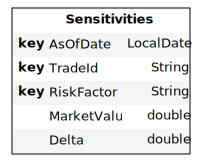

In [8]:
cube.schema

### Refining the cube

The `create_cube` command triggered the creation of default measures and dimensions, which can be further customized and refined, we are creating variables to access their collections:

In [9]:
m, lvl, h = cube.measures, cube.levels, cube.hierarchies

The following cell **hides the created measures** for the mean:

In [10]:
m["MarketValue.MEAN"].visible = False
m["Delta.MEAN"].visible = False

The next cell is making the date dimension slicing, so that there's no summation across dates:

In [11]:
h["AsOfDate"].slicing = True

The next cell will sort dates in desc order:

In [12]:
lvl["AsOfDate"].order = tt.NaturalOrder(ascending=False)

Please refer to the Atoti documentation to learn about other ways to refine your cube, in particular about creating custom aggregation functions: [New measures](https://docs.atoti.io/0.4.1/tutorial/01-Basics.html#New-measures).

#### Data visualization

Let's do a quick visualization to view the Market Value and Delta measures from the initial source file.  
The following command serves for a quick inline Atoti visualization:

In [13]:
session.visualize("Initial risk data")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

We are expecting new files to be loaded into the directory. Using the popular [watchdog](https://github.com/gorakhargosh/watchdog) library, we overload the `on_created` event function to load the received file into the Atoti data table `Sensitivities`.  
There are other [watchdog events handlers](https://pythonhosted.org/watchdog/api.html#event-handler-classes) that you may consider using, depending on your use case.

By using watchdog, this allows us to implement conditional loading or have data preprocessing before loading them into the Atoti cube.

In [14]:
watch_directory = "./dynamic-input-files"
if not os.path.exists(watch_directory):
    os.makedirs(watch_directory)

In [15]:
class AtotiWatcher(FileSystemEventHandler):
    def on_created(self, event: FileCreatedEvent):
        try:
            filename = os.path.basename(event.src_path)
            if filename != "dynamic-input-files":
                print("New file received", filename)
                sensitivities_table.load_csv(event.src_path)
                print("File loaded", event.src_path)
        except Exception as error:
            print(error)

    def on_modified(self, event: FileCreatedEvent):
        try:
            filename = os.path.basename(event.src_path)
            if filename != "dynamic-input-files":
                print("File modified", filename)
                sensitivities_table.load_csv(event.src_path)
                print("Modified file loaded", event.src_path)
        except Exception as error:
            print(error)


observer = PollingObserver()
observer.schedule(AtotiWatcher(), watch_directory)
observer.start()

### Real-time data loading: Loading a new file to the directory 

Let's download portfolio from the previous business day into the same folder

In [16]:
wget.download(
    "https://data.atoti.io/notebooks/real-time-risk/static-input-files/risk_data_previous_cob.csv",
    "./dynamic-input-files",
)

100% [................................................................................] 1256 / 1256

'./dynamic-input-files/risk_data_previous_cob (1).csv'

In [17]:
session.visualize("Risk data after uploading 8th of July")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

### Real-time data loading: Modifying an existing file

We will modify the previously downloaded risk_data_previous_cob.csv to include the previous day risk data.

In [18]:
previous_cob_df = pd.read_csv("./dynamic-input-files/risk_data_previous_cob.csv")
previous_cob_df["AsOfDate"] = pd.DatetimeIndex(
    previous_cob_df["AsOfDate"]
) + pd.DateOffset(-1)
previous_cob_df.head()

,AsOfDate,TradeId,RiskFactor,MarketValue,Delta
0,2020-07-07,Trd_0,MSFT,99.049795,6125.737500
1,2020-07-07,Trd_1,OXY,9.086285,198.409124
2,2020-07-07,Trd_2,AAPL,78.826585,16132.143066
3,2020-07-07,Trd_3,MSFT,99.124606,6216.607731
4,2020-07-07,Trd_4,OXY,0.780461,-349.011094


The below will append the updated data back to the same CSV.

In [19]:
previous_cob_df.to_csv(
    "./dynamic-input-files/risk_data_previous_cob.csv",
    index=False,
    mode="a",
    header=False,
)

In [20]:
session.visualize("Risk data after data file modification")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

Uncomment these commands to stop the folder monitoring. However, we will still require the folder monitoring in the later user case. Hence, the monitoring will be stopped later on.

In [21]:
# observer.stop()
# observer.join()

### 2. Real-time via datastore `append` function

To implement real-time instrument prices, we’ll be pushing new values using the datastore `append` command. In the following cell, we're creating the `market_data_table`. As you probably noticed, we are not setting the `watch` parameter as in the previous example, as it defaults to `False`:

In [22]:
market_data_table = session.read_csv(
    "s3://data.atoti.io/notebooks/real-time-risk/static-input-files/market_data.csv",
    keys=["AsOfDate", "Instrument"],
    table_name="Market_Data_table",
    types={
        "AsOfDate": tt.type.LOCAL_DATE,
        "Instrument": tt.type.STRING,
        "Quote": tt.type.DOUBLE,
    },
)

File modified risk_data_previous_cob (1).csv
Modified file loaded ./dynamic-input-files\risk_data_previous_cob (1).csv
File modified risk_data_previous_cob.csv
Modified file loaded ./dynamic-input-files\risk_data_previous_cob.csv


Displaying the current state of the `market data store`:

In [23]:
market_data_table.head(5)

Quote
AsOfDate   Instrument       
2020-07-08 OXY         16.23
           MSFT        214.0
           AAPL        380.0

At any time, we can use the `append` command to inject new records, for example:

In [24]:
asOfDate = datetime(2020, 7, 9)

market_data_table.append((asOfDate, "AAPL", 381.0))
market_data_table.append((asOfDate, "OXY", 16.8))
market_data_table.append((asOfDate, "MSFT", 215.0))
market_data_table.head(5)

Quote
AsOfDate   Instrument       
2020-07-08 OXY         16.23
           MSFT        214.0
           AAPL        380.0
2020-07-09 AAPL        381.0
           OXY          16.8

This `join` will link the `sensitivities_table` and the `market_data_table` and allow displaying sensitivities next to quotes.

In [25]:
sensitivities_table.join(
    market_data_table,
    (sensitivities_table["AsOfDate"] == market_data_table["AsOfDate"])
    & (sensitivities_table["RiskFactor"] == market_data_table["Instrument"]),
)

Current state of the data model can be visualized by the following command:

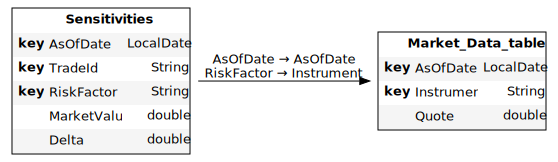

In [26]:
cube.schema

In [27]:
m["Quote.VALUE"] = tt.agg.single_value(market_data_table["Quote"])

In [28]:
session.visualize("Quotes next to Deltas and MarketValues")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

# Enriching risk data - trade attributes and multi-level book structure

To facilitate the analysis, we can enrich the metrics with additional attributes such as risk factors, regions, sectors, trade typologies, etc. 

In this example, we are adding trade attribute data and linking trades to a multi-level booking hierarchy. 

In [29]:
trade_attributes = session.read_csv(
    "s3://data.atoti.io/notebooks/real-time-risk/static-input-files/trade_attributes.csv",
    types={"TradeId": tt.type.STRING, "Strike": tt.type.STRING},
    keys=["TradeId"],
    table_name="Trade_Attributes",
)

trade_attributes.head()

,Ticker,Book,Product,Quantity,Strike,Maturity,OptionType
TradeId,,,,,,,
Trd_18,MSFT,EQ_LARG_DM,EQ_Option,-100,213.13999938964844,2039-04-20,call
Trd_19,MSFT,EQ_WAREHOU,EQ_Option,-100,213.3800048828125,2024-12-25,put
Trd_0,MSFT,EQ_SMAL_EM,EQ_Option,-100,212.341796875,2033-11-24,put
Trd_1,OXY,EQ_WAREHOU,EQ_Option,-50,16.48699951171875,2040-03-21,put
Trd_2,AAPL,EQ_STRUCT,EQ_Option,-100,384.6700134277344,2023-01-26,call


In [30]:
sensitivities_table.join(trade_attributes)

In [31]:
book_hierarchy = session.read_pandas(
    pd.DataFrame(
        data={
            "Book": [
                "EQ_VOL_HED",
                "EQ_STRUCT",
                "EQ_LARG_DM",
                "EQ_WAREHOU",
                "EQ_SMAL_EM",
            ],
            "Desk": [
                "Structuring",
                "Structuring",
                "Equity Trading",
                "Equity Trading",
                "Equity Trading",
            ],
            "Business Unit": [
                "Equities",
                "Equities",
                "Equities",
                "Equities",
                "Equities",
            ],
        }
    ),
    keys=["Book"],
    table_name="Book_Hierarchy",
)

trade_attributes.join(book_hierarchy)

Current state of the data model:

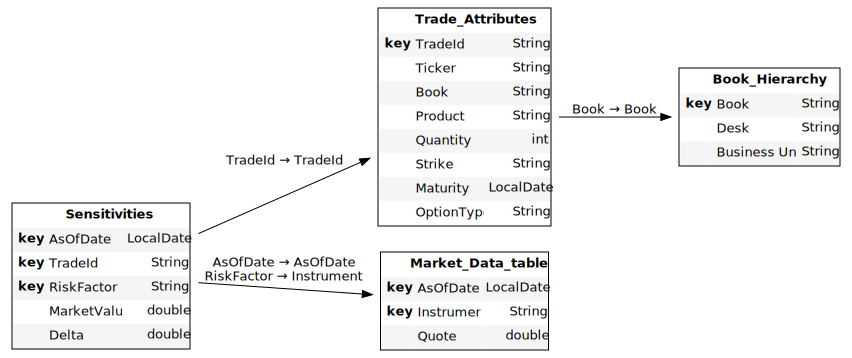

In [32]:
cube.schema

In [33]:
# from v0.6.0 int and long table columns in base stores automatically become measures instead of levels unless they are keys.
m["Quantity"] = tt.agg.sum(trade_attributes["Quantity"])

In fact, the **attributes do not have to be static**. They can be refreshed as soon as data arrives. For example, by adding a “Trade status” into the `trade_attributes` store I could use it to tag trades as “Terminated” and filter them out from the view.

In the following cell, we are creating a hierarchy representing ogranisational structure:

In [34]:
h["Portfolio Structure"] = {
    "Business Unit": lvl["Business Unit"],
    "Desk": lvl["Desk"],
    "Book": lvl["Book"],
}

We can expand and collapse data along the multi-level hierarchy:

In [35]:
session.visualize()

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

Current data model schema:

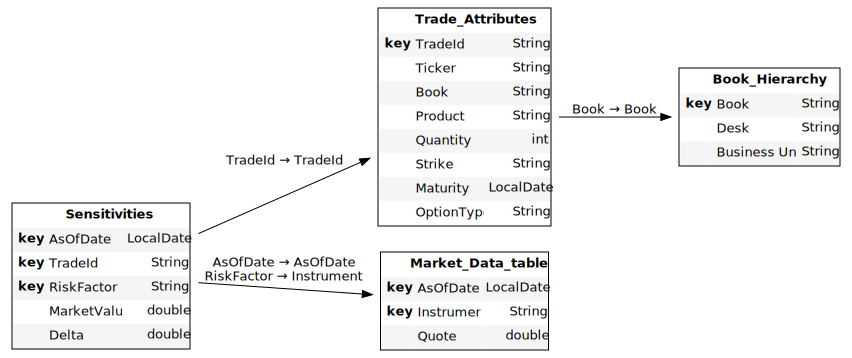

In [36]:
cube.schema

# Start real-time sources

In the following section I'm emulating a market data feed, which is triggering portfolio repricing. 

A pricing library is mocked up by a function computing greeks using a QuantLib implementation of the Black-Scholes formulae. 

In [37]:
## Uncomment these lines if you wish to install QuantLib
# import sys

# !{sys.executable} -m pip install QuantLib

In [38]:
from pricing_engine_emulator import reprice_portfolio, reprice_trade

Open a dashboard via this link - you will see the most recent portfolio summary. The widgets are switched to the "real-time" query mode, but the data is not updating just yet. Run the subsequent cells to "start" the real-time and watch cells blinking.

In [39]:
session.link(path="/#/dashboard/8b4")

Open the notebook in JupyterLab with the Atoti extension enabled to see this link.

To simulate the market data updates, I am going to replay simulated historical stock prices. This code snippet downloads historical data and pushes new tick updates into a queue. The publisher waits for the `should_publish` event, which is triggered in the subsequent cells.

In [40]:
should_publish = threading.Event()

spot_update_queue = queue.Queue()
tick_data = pd.read_csv(
    "https://data.atoti.io/notebooks/real-time-risk/static-input-files/stock_price_tick_data.csv",
    index_col="AsOfDate",
    parse_dates=["AsOfDate"],
)
positions = pd.read_csv(
    "https://data.atoti.io/notebooks/real-time-risk/static-input-files/trade_attributes.csv",
    parse_dates=["Maturity"],
)


def start_spot_publisher():
    # The publisher is replaying tick_data.
    # It waits for the should publish event (see subsequent cells to trigger).

    current_time = -1
    for idx, row in tick_data.iterrows():
        next_time = idx
        if current_time != -1:
            dt = (next_time - current_time).total_seconds() / 100.0
            time.sleep(dt)
        current_time = idx
        print("\rawaiting for publishing update " + str(idx), end="")
        should_publish.wait()
        print("\rpublishing update " + str(idx), end="")
        spot_update_queue.put((idx, row.to_dict()))
    spot_update_queue.join()
    print("All work completed")


def start_spot_update_listener():
    print("Real time updates started")
    while True:
        calc_date, spot_prices_by_ticker = spot_update_queue.get()
        """
        As discussed above, I'm illustrating the "reactive" data store 
        by configuring it with the parameter watch set to True.
        With the following code I'm updating the file on disc:
        """
        reprice_portfolio(spot_prices_by_ticker, positions, calc_date).to_csv(
            "dynamic-input-files/risk_data.csv", index=False
        )

        """
        The second example of real-time implementation - is injecting the data 
        directly into a datastore.
        With the following code I'm appending the new stock prices to the market data store.
        """
        for i in list(spot_prices_by_ticker.items()):
            if not pd.isnull(i[1]):
                clear_output(wait=True)
                print((calc_date.date(), i[0], i[1]))
                market_data_table.append((calc_date.date(), i[0], i[1]))

        spot_update_queue.task_done()


listener_thread = threading.Thread(target=start_spot_update_listener, daemon=True)
publisher_thread = threading.Thread(target=start_spot_publisher, daemon=True)


Run the next cell to start the real-time feeds - and see the cells in the dashboards blinking if then contributing data changes.

In [41]:
publisher_thread.start()
listener_thread.start()
# start publishing
should_publish.set()

(datetime.date(2020, 7, 9), 'OXY', 16.37)


In [42]:
# pause publishing
should_publish.clear()

#### Stopping watchdog folder monitoring

Run the below to stop the watchdog event monitoring the folder for incoming files.

In [43]:
observer.stop()
observer.join()

# 3. Kafka feed and a custom deserializer

The above real-time feeds are illustrating the file **watch** and the **append** command. Now let's have a quick look at enabling a **kafka feed** for a  datastore.

I'm using [Bitnami Docker Image for Kafka](https://hub.docker.com/r/bitnami/kafka/) to run kafka. While the [docker-compose.yml](.docker-compose.yml) is included in this project directory, you can download it with the following command:

```
curl -sSL https://raw.githubusercontent.com/bitnami/containers/main/bitnami/kafka/docker-compose.yml > docker-compose.yml
```

The following parameter has been added to the kafka environment section in the docker-compose.yaml - this makes Kafka accessible from outside the container.  
```
- KAFKA_CFG_ADVERTISED_LISTENERS=PLAINTEXT://127.0.0.1:9092
```

![Docker config](./img/docker-config.png)

### <u>Do the following in your environment to start the Docker containers and create the Kafka producer and consumer</u>  

Then I'm using docker-compose to launch kafka:

```
docker-compose up -d
```

And then [creating a topic](https://docs.bitnami.com/aws/infrastructure/kafka/administration/run-producer-consumer/) for trades and sensitivites:

```
docker exec -it real-time-risk-kafka-1 /opt/bitnami/kafka/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --topic trades --partitions 3 --replication-factor 1

docker exec -it real-time-risk-kafka-1 /opt/bitnami/kafka/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --topic sensitivities --partitions 3 --replication-factor 1
```

From Atoti v0.5.0 onwards, we can import the `atoti_kafka` package to load real-time Kafka streams into Atoti table.

In [44]:
import atoti_kafka

Let's point the `sensitivities` and `trades_attributes` to the respective kafka feed. Atoti will consume the arriving sensitivities and trades data, and the widgets will refresh automatically (need to toggle them to real-time mode - as described in the Atoti for real-time section above)

For a complete list of the Atoti's `load_kafka` parameters, please refer to the doc [load_kafka](https://docs.atoti.io/latest/lib/atoti/atoti.table.html#atoti.Table.load_kafka). In this example, I set `batch_duration` to `0` such that received records are immediately publihed to the table. To demonstrate how `consumer_config` is being used, we set the `auto.offset.reset` value to `latest` to move to the latest available message.

In [45]:
sensitivities_table.load_kafka(
    bootstrap_server="localhost:9092",
    topic="sensitivities",
    group_id="atoti-risk-consumer",
    consumer_config={"auto.offset.reset": "latest"},
    batch_duration=0,
)

In [46]:
trade_attributes.load_kafka(
    bootstrap_server="localhost:9092",
    topic="trades",
    group_id="atoti-trades-consumer",
    consumer_config={"auto.offset.reset": "latest"},
    batch_duration=0,
)

I'll be using python kafka module to push new trade events. In the next cell, I'm sending a first sensitivities and trade message.

In [47]:
# # Uncomment these lines if you wish to install kafka-python
# import sys

# !conda install  -c conda-forge --yes --prefix {sys.prefix} kafka-python

In [48]:
# using kafka python module to publish messages
from kafka import KafkaProducer

producer = KafkaProducer(
    value_serializer=lambda v: json.dumps(v).encode("utf-8"),
    bootstrap_servers=["127.0.0.1:9092"],
)

Click on the below dashboard to observe the incoming trades.

In [49]:
session.link(path="/#/dashboard/8b4")

Open the notebook in JupyterLab with the Atoti extension enabled to see this link.

I'll only be able to query my trade if the sensitivities are loaded into the cube since `sensitivities` table is the base table of the cube.  
Below are the columns of the `sensitivities` table and they have to be available in the sensitivies message.

In [50]:
sensitivities_table.columns

['AsOfDate', 'TradeId', 'RiskFactor', 'MarketValue', 'Delta']

Run this cell and check in the dashboard that the "New_Trd_Test" has arrived - expected on top of the "Trades Blotter" table. Do note that information such as Ticker, Book and Product which is coming from the `trade_attributes` table may not be available until the corresponding trade data is loaded into the `trade_attributes` table. 

In [51]:
# Test sensitivities
sensitivities = {
    "AsOfDate": "2020-07-09",
    "TradeId": "New_Trd_Test",
    "MarketValue": 89.43425919208067,
    "RiskFactor": "OXY",
    "Delta": 103.34,
}

l = producer.send("sensitivities", sensitivities)

Below are the columns of the `trade_attributes` table and they have to be available in the trade message.

In [52]:
trade_attributes.columns

['TradeId',
 'Ticker',
 'Book',
 'Product',
 'Quantity',
 'Strike',
 'Maturity',
 'OptionType']

After executing the next cell, we should see the Product, Book and Strike appearing under the `Trades Blotter` widget for the new trade.

In [53]:
# Test trade
trd = {
    "TradeId": "New_Trd_Test",
    "Ticker": "OXY",
    "Book": "EQ_VOL_HED",
    "Product": "EQ_Option",
    "Quantity": 45,
    "Strike": -31.41249430583221,
    "Maturity": "2022-10-01",
    "OptionType": "put",
    # "MarketValue": 89.43425919208067,
}

l = producer.send("trades", trd)

To see the messages, the following command can be run:
    
```
docker exec -it real-time-risk_kafka_1 /opt/bitnami/kafka/bin/kafka-console-consumer.sh --bootstrap-server localhost:9092 --topic trades --from-beginning
docker exec -it real-time-risk_kafka_1 /opt/bitnami/kafka/bin/kafka-console-consumer.sh --bootstrap-server localhost:9092 --topic sensitivities --from-beginning
```

In the following cell, I'm creating a function that will generate random trades.

In [54]:
def generate_a_new_trade(id):
    # this function is generating trades data (random)

    trade_id = "New_Trade_" + str(id)
    ticker = random.choice(["AAPL", "MSFT", "OXY"])

    trade = {
        "TradeId": trade_id,
        "Ticker": ticker,
        "Book": random.choice(
            ["EQ_LARG_DM", "EQ_SMAL_EM", "EQ_STRUCT", "EQ_VOL_HED", "EQ_WAREHOU"]
        ),
        "Product": "EQ_Option",
        "Quantity": random.randrange(-100, 100),
        "Strike": random.uniform(-100, 100),
        "Maturity": "2022-10-01",
        "OptionType": "put",
    }

    print("A new trade generated:")
    print(json.dumps(trade, indent=4))

    sensitivities = {
        "AsOfDate": "2020-07-09",
        "TradeId": trade_id,
        "RiskFactor": ticker,
        "MarketValue": random.uniform(-100, 100),
        "Delta": random.uniform(-100, 100),
    }

    print("A new sensitivities generated:")
    print(json.dumps(sensitivities, indent=4))

    return trade, sensitivities

Let's check that we can see updates in the real-time dashboard:

In [55]:
session.link(path="/#/dashboard/8b4")

Open the notebook in JupyterLab with the Atoti extension enabled to see this link.

Run the following cell to publish a few new trades and see them appearing in the "Trades Blotter" widget

In [56]:
for i in range(20, 0, -1):
    new_trade, new_sensitivities = generate_a_new_trade(i)

    producer.send("trades", new_trade)
    producer.send("sensitivities", new_sensitivities)
    print("Published.\n")
    time.sleep(1)
    clear_output(wait=True)

A new trade generated:
{
    "TradeId": "New_Trade_1",
    "Ticker": "MSFT",
    "Book": "EQ_LARG_DM",
    "Product": "EQ_Option",
    "Quantity": 87,
    "Strike": -62.30058936899634,
    "Maturity": "2022-10-01",
    "OptionType": "put"
}
A new sensitivities generated:
{
    "AsOfDate": "2020-07-09",
    "TradeId": "New_Trade_1",
    "RiskFactor": "MSFT",
    "MarketValue": -71.08639134809619,
    "Delta": 32.34341105216572
}
Published.



<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=real-time-risk" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Try+Atoti.jpg" alt="Try Atoti"></a></div>